In [27]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16

In [28]:
# help(VGG16)

In [29]:
vgg16 = VGG16(weights='imagenet',include_top=False,
              input_shape=(32, 32, 3))
# VGG16 模型在include_top=False时，可以自定义输入大小，至少32x32，通道必须是3
for layer in vgg16.layers[:15]:
    layer.trainable = False

addmodel = Sequential()
addmodel.add(Flatten(input_shape=vgg16.output_shape[1:]))
addmodel.add(Dense(256, activation='relu'))
addmodel.add(Dropout(0.3))
addmodel.add(Dense(10, activation='softmax'))

model = Model(inputs=vgg16.inputs, outputs=addmodel(vgg16.outputs))

In [30]:
train = pd.read_csv('train.csv')
y_train_full = train['label']
X_train_full = train.drop(['label'], axis=1)
X_test_full = pd.read_csv('test.csv')

In [31]:
X_train_full.shape

(42000, 784)

In [32]:
def process(data):
    data = np.array(data).reshape(-1,28,28) / 255.0
    output = np.zeros((data.shape[0], 32, 32, 3))
    for i in range(data.shape[0]):
        img = data[i]
        rgb_array = np.zeros((img.shape[0], img.shape[1], 3), "uint8")
        rgb_array[:, :, 0], rgb_array[:, :, 1], rgb_array[:, :, 2] = img, img, img
        pic = cv2.resize(rgb_array, (32, 32), interpolation=cv2.INTER_LINEAR)
        output[i] = pic
    return output

In [48]:
y_train = np_utils.to_categorical(y_train_full, 10)
X_train = process(X_train_full)
X_test = process(X_test_full)

print(X_train.shape)
print(X_test.shape)

(42000, 32, 32, 3)
(28000, 32, 32, 3)


In [34]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])

263/263 [==============================] - 533s 2s/step - loss: 2.2891 - accuracy: 0.1160 - val_loss: 2.2728 - val_accuracy: 0.1288


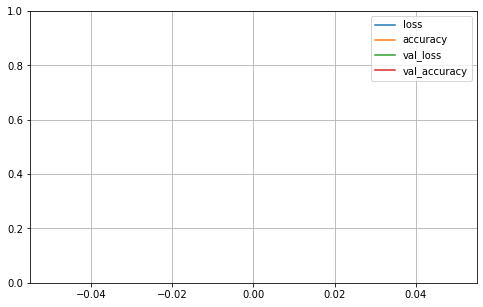

In [35]:
history = model.fit(X_train, y_train, epochs=1, batch_size=128,
                    validation_split=0.2)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [36]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

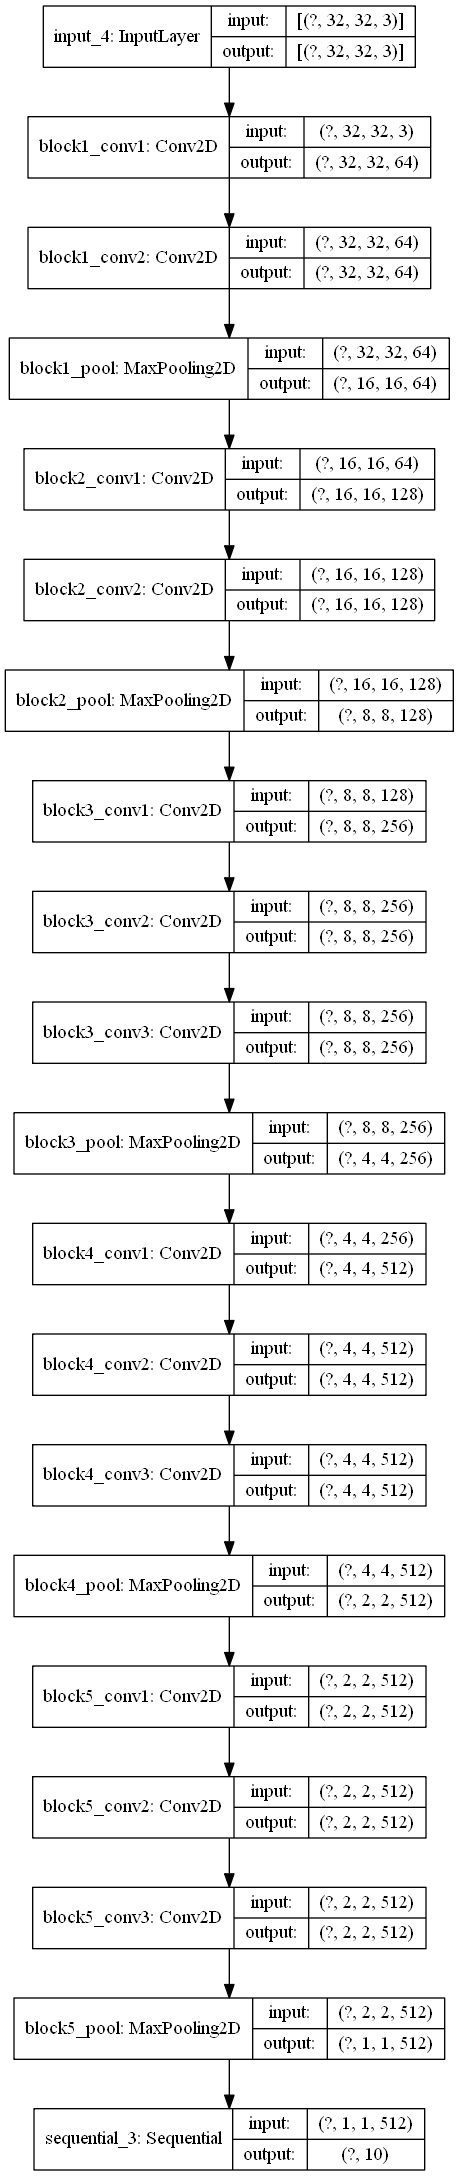

In [37]:
from keras.utils import plot_model
plot_model(model, './model.png', show_shapes=True)

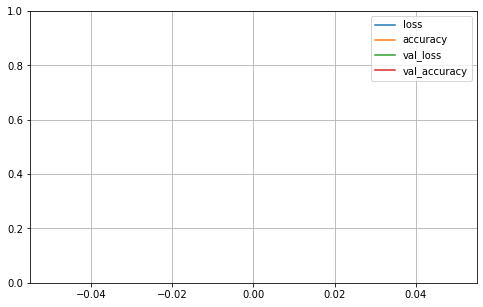

In [38]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [39]:
y_pred = model.predict(X_test)


In [45]:
pred = y_pred.argmax(axis=1).reshape(-1)
print(pred.shape)
image_id = pd.Series(range(1,len(pred)+1))
output = pd.DataFrame({'ImageId':image_id, 'Label':pred})
output.to_csv("submission_NN.csv",  index=False)

(28000,)
